# A Python application for visualizing an imbricate thrust system: Palomeque Duplex (SE, Spain)

We import the math libraries, data analysis libraries and image libraries.

In [1]:
# math libraries

import numpy as np
import sympy

from sympy import *
t = Symbol('t')

from scipy.interpolate import interp2d
from scipy.interpolate import griddata

import math

# data analysis library


import pandas as pd


# import plotting libraries

import plotly.offline as go_offline
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

# imaging library

from PIL import Image

We set the data and imagen directories

In [2]:
DATADIR='data/' # Directory with the data
FIGURESDIR='figures/' # Figures produced

## Topography

To obtain the topography of the study area we delimited the area and then used the Copernicus DEM tiff image eu_dem_v11_E30N10.Tiff. Since this image weighs 1.1 G, we crop it to get a smaller image that looks like

In [3]:
Im=Image.open(FIGURESDIR+'eu_dem_v11_E30N10_crop.png')

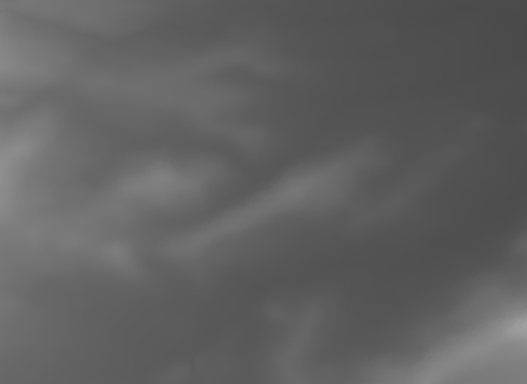

In [4]:
Im

We build a mesh, each point of this mesh is given by its UTM_X, UTM_Y and elevation. The data for this mesh is saved as a cvs file that we open.

In [5]:
# Topografy data

topo=pd.read_csv(DATADIR+'topografy.csv')

In [6]:
topo

UTM_X         UTM_Y    elevation
0     618131.414840  4.197675e+06   702.294556
1     618132.694676  4.197586e+06   707.380493
2     618133.974489  4.197497e+06   722.496460
3     618135.254279  4.197409e+06   721.459595
4     618136.534045  4.197320e+06   732.357910
...             ...           ...          ...
2585  623304.834524  4.195087e+06  1092.907593
2586  623306.169278  4.194999e+06  1152.172607
2587  623307.504009  4.194910e+06  1132.570068
2588  623308.838716  4.194821e+06  1062.827759
2589  623310.173398  4.194732e+06   986.483154

[2590 rows x 3 columns]

We split the data in topo to get three numpy arrays

In [7]:
topo1=topo[['UTM_X','UTM_Y','elevation']].to_numpy()

topox=[x[0] for x in topo1]
topoy=[x[1] for x in topo1]
topoelv=[x[2] for x in topo1]

In the list cotasxy we save the dimensions of the model.

In [8]:
cotasxy=[min(topox)+200,max(topox)-2000,min(topoy)+100,max(topoy)-200]

The following function <span style="color:blue">surface</span> interpolates the data on a grid of points, the interpolation method can be linear, cubic or nearest.

In [9]:
def surface(grid,metodo): #metodo='linear', 'cubic' o 'nearest'

    tx=grid[0]
    ty=grid[1]
    tz=grid[2]

    X = np.linspace(min(tx), max(tx))
    Y = np.linspace(min(ty), max(ty))
    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
    Z = griddata((tx,ty),tz,(X,Y), 
                 method=metodo)
    
    return [tx,ty,tz,X,Y,Z]

We choose the linear interpolation method and apply it to the topographic data.

In [10]:
topo_gr=[topox,topoy,topoelv]
topo_linear=surface(topo_gr,'linear')

We are ready to create the figure that realizes the 3D model. We use two color scales 'YlGn' and 'gray' to get more depth in the model.

In [11]:
fig=go.Figure()

# topografía

fig.add_trace(go.Surface(  x=topo_linear[3],y=topo_linear[4],z=topo_linear[5],
                           colorscale='YlGn',
                           opacity = 0.8,
                           name='Topography',
                           legendgroup='topo',
                           showlegend=True,
                           showscale=False))
fig.add_trace(go.Surface(  x=topo_linear[3],y=topo_linear[4],z=topo_linear[5],
                           colorscale='gray',
                           opacity = 0.3,
                           name='Topo',
                           legendgroup='topo',
                           showlegend=False,
                           showscale=False))

camera = dict(up=dict(x=0, y=0, z=1),
              center=dict(x=0, y=0, z=0),
               eye=dict(x=0, y=-1, z=2) )

fig.update_layout( title="Topography Model",
                  #paper_bgcolor = 'black',
                 scene = dict(
                     xaxis=dict(title='UTM_X', 
                                tickfont = dict(size = 10,color = 'black'),
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[cotasxy[0],cotasxy[1]],
                                backgroundcolor='white',
                                color='black',
                                gridcolor='gray'),
                     yaxis=dict(title='UTM_Y',
                                tickfont = dict(size = 10,color = 'black'),
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[cotasxy[2],cotasxy[3]],  
                                backgroundcolor='white',
                                color='black',
                                gridcolor='gray'),
                      zaxis=dict(nticks=4,
                                tickfont = dict(size = 10,color = 'black'),
                                title='Elevation', 
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[500,1000],
                                backgroundcolor='white',
                                color='black', 
                                gridcolor='gray'),
                     aspectratio=dict(x=2, y=1.8, z=0.3)),
                     #aspectmode='data'),
                     scene_camera= camera
                 ) 
              

fig.show()

## Contacts and faults

With the following function <span style="color:blue">contact_tr</span> we process the data from the cvs files in which the stratigraphic and mechanical data are stored

In [12]:
def contact_tr(csv,aumento_elevacion):
    tr=pd.read_csv(csv)
    tr1=tr[['x','y','SAMPLE_1']].to_numpy()
    tx=[x[0] for x in tr1]
    ty=[x[1] for x in tr1]
    telv=[x[2]+aumento_elevacion for x in tr1]
    return [tx,ty,telv]


Load and process the data

In [13]:
# mechanic contacts ????

palomeque=contact_tr(DATADIR+'palomeque.csv',0)+['palomeque_thrust']
palomeque_ds=contact_tr(DATADIR+'palomeque_ds.csv',0)+['palomeque_desplazado']
calvillo=contact_tr(DATADIR+'calvillo.csv',0)+['calvillo_thrust']
calvillo_ds=contact_tr(DATADIR+'calvillo_ds.csv',0)+['calvillo_desplazado']

# faults

fault2=contact_tr(DATADIR+'fault2.csv',0)+['fault2']
fault1=contact_tr(DATADIR+'fault1.csv',0)+['fault1']
fault3=contact_tr(DATADIR+'fault3.csv',0)+['fault1']

# stratigraphic contacts ?????

E12cal=contact_tr(DATADIR+'E1E2 calvillo.csv',0)+['E1-E2 calvillo']
E12pal=contact_tr(DATADIR+'E1E2 palomeque.csv',0)+['E1-E2 palomeque']
E23pal=contact_tr(DATADIR+'E2E3 palomeque.csv',0)+['E2-E3 palomeque']
E3Opal=contact_tr(DATADIR+'E3O palomeque.csv',0)+['E3-O palomeque']
PEpal=contact_tr(DATADIR+'PE palomeque.csv',0)+['P-E palomeque']
PEcal=contact_tr(DATADIR+'PE calvillo.csv',0)+['P-E calvillo']
E12cal_ds=contact_tr(DATADIR+'E1E2 calvillo_ds.csv',0)+['E1-E2 calvillo ds']
E12pal_ds=contact_tr(DATADIR+'E1E2 palomeque_ds.csv',0)+['E1-E2 palomeque ds']



The following function <span style="color:blue">contact_dat</span> uses the comad Scatter3d to 
create de contact data for the figure.

In [14]:
def contact_dat(x,y,elv,h,mode,nam,color,gr,t,ls):
    z=[x+h for x in elv]
    return go.Scatter3d(x=x, y=y, z=z,
            mode =mode,
            name=nam,
            legendgroup=gr,
            showlegend=t,
            line=dict(color=color,
                      dash=ls,
                      width=5)
                        )

In [15]:
cont=[palomeque_ds,palomeque,calvillo,calvillo_ds]
cab=[E12cal,E12pal,E23pal,E3Opal,PEpal,PEcal,E12cal_ds,E12pal_ds]
fal=[fault1,fault2,fault3]

contacts=[contact_dat(palomeque_ds[0],palomeque_ds[1],palomeque_ds[2],30,
                        "lines",'Thrusts','black','contacts',True,None)
          ]+[contact_dat(x[0],x[1],x[2],30,"lines",x[3],'black','contacts',False,None) for x in cont[1:]]

cabs=[contact_dat(E12cal[0],E12cal[1],E12cal[2],30,"lines",'Stratigraphic contacts','black',
                            'cabalgamientos',True,'dot')
              ]+[contact_dat(x[0],x[1],x[2],30,"lines",x[3],'black','cabalgamientos',False,'dot') for x in cab[1:]]

faults=[contact_dat(fault1[0],fault1[1],fault1[2],50,"lines",'Strike-slip faults','black','faults',True,None)
      ]+[contact_dat(x[0],x[1],x[2],30,"lines",x[3],'black','faults',False,None) for x in fal[1:]]


In [16]:
fig=go.Figure(contacts+cabs+faults)

# topography

fig.add_trace(go.Surface(  x=topo_linear[3],y=topo_linear[4],z=topo_linear[5],
                           colorscale='YlGn',
                           opacity = 0.8,
                           name='Topography',
                           legendgroup='topo',
                           showlegend=True,
                           showscale=False))
fig.add_trace(go.Surface(  x=topo_linear[3],y=topo_linear[4],z=topo_linear[5],
                           colorscale='gray',
                           opacity = 0.3,
                           name='Topo',
                           legendgroup='topo',
                           showlegend=False,
                           showscale=False))

camera = dict(up=dict(x=0, y=0, z=1),
              center=dict(x=0, y=0, z=0),
               eye=dict(x=0, y=-1, z=2) )

fig.update_layout( title="Topography Model",
                  #paper_bgcolor = 'black',
                 scene = dict(
                     xaxis=dict(title='UTM_X', 
                                tickfont = dict(size = 10,color = 'black'),
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[cotasxy[0],cotasxy[1]],
                                backgroundcolor='white',
                                color='black',
                                gridcolor='gray'),
                     yaxis=dict(title='UTM_Y',
                                tickfont = dict(size = 10,color = 'black'),
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[cotasxy[2],cotasxy[3]],  
                                backgroundcolor='white',
                                color='black',
                                gridcolor='gray'),
                      zaxis=dict(nticks=4,
                                tickfont = dict(size = 10,color = 'black'),
                                title='Elevation', 
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[500,1000],
                                backgroundcolor='white',
                                color='black', 
                                gridcolor='gray'),
                     aspectratio=dict(x=2, y=1.8, z=0.3)),
                     #aspectmode='data'),
                     scene_camera= camera
                 ) 
              

fig.show()


We add texts for heights and Stratigraphic levels to the figure

In [17]:
namesx=[619200,620800]
namesy=[4196500,4196250]
namesz=[850,850]
namestxt=['Calvillo height','Palomeque height','A','A$^\prime$']

tx=[calvillo[0][1]+50,calvillo[0][3],calvillo[0][4],calvillo[0][5],calvillo[0][7]]
ty=[calvillo[1][1]-50,calvillo[1][3]-50,calvillo[1][4]-70,calvillo[1][5]-50,calvillo[1][7]-70]
tz=[calvillo[2][1]+40,calvillo[2][3]+30,calvillo[2][4]+50,calvillo[2][5]+15,calvillo[2][7]+20]

In [18]:
nnx=[618900,619350,620200,619350,619400,620120,620700,
     618850,619200,620900,621100,619700]
nny=[4196800,4196700,4196400,4196200,4196000,4196100,4196000,
     4195500,4195500,4195800,4195500,4195200]
nnz=[700,750,750,750,700,790,700,750,700,600,650,700]
nntxt=['M1','P','P','E1','E2','E1','E2','E1','E2','E3','O2','E1']

In [19]:
fig=go.Figure(contacts+cabs+faults)

# topography

fig.add_trace(go.Surface(  x=topo_linear[3],y=topo_linear[4],z=topo_linear[5],
                           colorscale='YlGn',
                           opacity = 0.8,
                           name='Topography',
                           legendgroup='topo',
                           showlegend=True,
                           showscale=False))
fig.add_trace(go.Surface(  x=topo_linear[3],y=topo_linear[4],z=topo_linear[5],
                           colorscale='gray',
                           opacity = 0.3,
                           name='Topo',
                           legendgroup='topo',
                           showlegend=False,
                           showscale=False))


trace = go.Scatter3d(
                   x=namesx, y=namesy, z=namesz,
                   text=namestxt,
                   name='Heights',
                   mode="text",
                   textfont=dict(color=["black","black"],size=13),
                   hoverinfo="skip")

fig.add_trace(trace)

trace2 = go.Scatter3d(
                   x=nnx, y=nny, z=nnz,
                   text=nntxt,
                   name='Stratigraphic levels',
                   mode="text",
                   legendgroup='cabalgamientos',
                   showlegend=False,
                   textfont=dict(color='black',size=18),
                   hoverinfo="skip")

fig.add_trace(trace2)


camera = dict(up=dict(x=0, y=0, z=1),
              center=dict(x=0, y=0, z=0),
               eye=dict(x=0, y=-1, z=2) )

fig.update_layout( title="Topography Model",
                  #paper_bgcolor = 'black',
                 scene = dict(
                     xaxis=dict(title='UTM_X', 
                                tickfont = dict(size = 10,color = 'black'),
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[cotasxy[0],cotasxy[1]],
                                backgroundcolor='white',
                                color='black',
                                gridcolor='gray'),
                     yaxis=dict(title='UTM_Y',
                                tickfont = dict(size = 10,color = 'black'),
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[cotasxy[2],cotasxy[3]],  
                                backgroundcolor='white',
                                color='black',
                                gridcolor='gray'),
                      zaxis=dict(nticks=4,
                                tickfont = dict(size = 10,color = 'black'),
                                title='Elevation', 
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[500,1000],
                                backgroundcolor='white',
                                color='black', 
                                gridcolor='gray'),
                     aspectratio=dict(x=2, y=1.8, z=0.3)),
                     #aspectmode='data'),
                     scene_camera= camera
                 ) 
              

fig.show()


To add triangles to the contact tracks we need some mathematical functions

In [20]:
def eq(A,B): # A and B are points
    x1, y1 = A
    x2, y2 = B
    # calculate the distance between the two points
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # calculate the angle between the two points
    angle = math.atan2(y2 - y1, x2 - x1)

    # calculate the coordinates of the third point (the first one)
    x3_1 = x1 + distance * math.cos(angle - (1 * math.pi / 3))
    y3_1 = y1 + distance * math.sin(angle - (1 * math.pi / 3))

    # calculate the coordinates of the third point (the second one)
    x3_2 = x1 + distance * math.cos(angle + (1 * math.pi / 3))
    y3_2 = y1 + distance * math.sin(angle + (1 * math.pi / 3))
    return[[x3_1,y3_1],[x3_2,y3_2]]

    

def tr(i,contacto,h,s,hh):
    A=(contacto[0][i],contacto[1][i])
    c1z=contacto[2][i]+h
    c2x=contacto[0][i+1]
    c2y=contacto[1][i+1]
    d=(c2x-A[0],c2y-A[1])
    nd=np.sqrt(d[0]**2+d[1]**2)
    dn=(d[0]/nd,d[1]/nd)
    B=(A[0]+dn[0]*150,A[1]+dn[1]*150)
    C=eq(A, B)[s]
    return [[A[0],B[0],C[0]],[A[1],B[1],C[1]],[c1z,c1z,c1z+hh]]

In [21]:
tcalvillo=[tr(1,calvillo,15,0,100),tr(3,calvillo,15,0,50),tr(5,calvillo,15,0,50),tr(7,calvillo,15,0,0)]

tcalvillo_dat=[go.Mesh3d(x=x[0],y=x[1],z=x[2],
                        alphahull=5, opacity=1, color='black',
                        i = np.array([0]),
                        j = np.array([1]),
                        k = np.array([2]),
                         legendgroup='contacts',
                         showlegend=False,
                       ) for x in tcalvillo]

tcalvillo_ds=[tr(1,calvillo_ds,25,1,30)]
tcalvillo_ds_dat=[go.Mesh3d(x=x[0],y=x[1],z=x[2],
                        alphahull=5, opacity=1, color='black',
                        i = np.array([0]),
                        j = np.array([1]),
                        k = np.array([2]),
                            legendgroup='contacts'
                       ) for x in tcalvillo_ds]

tpalomeque=[tr(1,palomeque,15,0,70),tr(4,palomeque,15,0,70),tr(5,palomeque,15,0,90),
            tr(6,palomeque,15,0,70),tr(7,palomeque,15,0,30)]

tpalomeque_dat=[go.Mesh3d(x=x[0],y=x[1],z=x[2],
                        alphahull=5, opacity=1, color='black',
                        i = np.array([0]),
                        j = np.array([1]),
                        k = np.array([2]),
                          legendgroup='contacts'
                       ) for x in tpalomeque]

tpalomeque_ds=[tr(1,palomeque_ds,5,1,0)]

tpalomeque_ds_dat=[go.Mesh3d(x=x[0],y=x[1],z=x[2],
                        alphahull=5, opacity=1, color='black',
                        i = np.array([0]),
                        j = np.array([1]),
                        k = np.array([2]), 
                        legendgroup='contacts',
                       ) for x in tpalomeque_ds]

The triangles data are stored in `tcont`.

In [22]:
tcont=tcalvillo_dat+tcalvillo_ds_dat+tpalomeque_dat+tpalomeque_ds_dat

In [23]:
fig=go.Figure(contacts+cabs+faults+tcont)

# topography

fig.add_trace(go.Surface(  x=topo_linear[3],y=topo_linear[4],z=topo_linear[5],
                           colorscale='YlGn',
                           opacity = 0.8,
                           name='Topography',
                           legendgroup='topo',
                           showlegend=True,
                           showscale=False))
fig.add_trace(go.Surface(  x=topo_linear[3],y=topo_linear[4],z=topo_linear[5],
                           colorscale='gray',
                           opacity = 0.3,
                           name='Topo',
                           legendgroup='topo',
                           showlegend=False,
                           showscale=False))


trace = go.Scatter3d(
                   x=namesx, y=namesy, z=namesz,
                   text=namestxt,
                   name='Heights',
                   mode="text",
                   textfont=dict(color=["black","black"],size=13),
                   hoverinfo="skip")

fig.add_trace(trace)

trace2 = go.Scatter3d(
                   x=nnx, y=nny, z=nnz,
                   text=nntxt,
                   name='Stratigraphic levels',
                   mode="text",
                   legendgroup='cabalgamientos',
                   showlegend=False,
                   textfont=dict(color='black',size=18),
                   hoverinfo="skip")

fig.add_trace(trace2)


camera = dict(up=dict(x=0, y=0, z=1),
              center=dict(x=0, y=0, z=0),
               eye=dict(x=0, y=-1, z=2) )

fig.update_layout( title="Topography Model",
                  #paper_bgcolor = 'black',
                 scene = dict(
                     xaxis=dict(title='UTM_X', 
                                tickfont = dict(size = 10,color = 'black'),
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[cotasxy[0],cotasxy[1]],
                                backgroundcolor='white',
                                color='black',
                                gridcolor='gray'),
                     yaxis=dict(title='UTM_Y',
                                tickfont = dict(size = 10,color = 'black'),
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[cotasxy[2],cotasxy[3]],  
                                backgroundcolor='white',
                                color='black',
                                gridcolor='gray'),
                      zaxis=dict(nticks=4,
                                tickfont = dict(size = 10,color = 'black'),
                                title='Elevation', 
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[500,1000],
                                backgroundcolor='white',
                                color='black', 
                                gridcolor='gray'),
                     aspectratio=dict(x=2, y=1.8, z=0.3)),
                     #aspectmode='data'),
                     scene_camera= camera
                 ) 
              

fig.show()


## Sections

Sections are determined by vertical planes which in turn are determined by two points. Let's build these sections. First we read the data an create the corresponding numpy arrays.

In [24]:
sections=pd.read_csv(DATADIR+'sections.csv')

sections1=sections[['UTM_X','UTM_Y','elevation','point']].to_numpy()
secx=[x[0] for x in sections1]
secy=[x[1] for x in sections1]
secelv=[x[2] for x in sections1]
secp=[x[3] for x in sections1]

In [25]:
# split the data
secx2=[(secx[i],secx[i+1]) for i in range(len(secx)-1)]
secy2=[(secy[i],secy[i+1]) for i in range(len(secx)-1)]
secelv2=[(secelv[i],secelv[i+1]) for i in range(len(secx)-1)]

In [26]:
sections_dat=[go.Scatter3d(x=secx2[i], y=secy2[i], z=[900 for x in secx2[i]],
            mode ='lines',
            name='Sections',
            legendgroup='sections',
            showlegend=True,
            line=dict(color='yellow',
                      width=5)
                        ) for i in range(0,len(secx2),2)]

We do not want a straight line to represent, for example, the section A-A$^\prime$ but a line that follows the topography. To get this line, we define points on the line and then we get their elevations. We save this data in the atopo.cvs file and do this process for each section. We also process the data to get numpy arrays.

In [27]:
# Topography A-A'

Atopo=pd.read_csv(DATADIR+'atopo.csv')


Atopo1=Atopo[['UTM_X','UTM_Y','elevation']].to_numpy()

Atopox=[x[0] for x in Atopo1]
Atopoy=[x[1] for x in Atopo1]
Atopoelv=[x[2] for x in Atopo1]

ca=[Atopox,Atopoy,Atopoelv,'A-A$^\prime$']

In [28]:
# Topography B-B'

Btopo=pd.read_csv(DATADIR+'Btopo.csv')


Btopo1=Btopo[['UTM_X','UTM_Y','elevation']].to_numpy()

Btopox=[x[0] for x in Btopo1]
Btopoy=[x[1] for x in Btopo1]
Btopoelv=[x[2] for x in Btopo1]

cb=[Btopox,Btopoy,Btopoelv,'B-B$^\prime$']

# Topography C-C'

Ctopo=pd.read_csv(DATADIR+'Ctopo.csv')


Ctopo1=Ctopo[['UTM_X','UTM_Y','elevation']].to_numpy()

Ctopox=[x[0] for x in Ctopo1]
Ctopoy=[x[1] for x in Ctopo1]
Ctopoelv=[x[2] for x in Ctopo1]

cc=[Ctopox,Ctopoy,Ctopoelv,'C-C$^\prime$']

# Topography D-D'

Dtopo=pd.read_csv(DATADIR+'Dtopo.csv')


Dtopo1=Dtopo[['UTM_X','UTM_Y','elevation']].to_numpy()

Dtopox=[x[0] for x in Dtopo1]
Dtopoy=[x[1] for x in Dtopo1]
Dtopoelv=[x[2] for x in Dtopo1]

cd=[Dtopox,Dtopoy,Dtopoelv,'D-D$^\prime$']

# Topography E-E'

Etopo=pd.read_csv(DATADIR+'Etopo.csv')


Etopo1=Etopo[['UTM_X','UTM_Y','elevation']].to_numpy()

Etopox=[x[0] for x in Etopo1]
Etopoy=[x[1] for x in Etopo1]
Etopoelv=[x[2] for x in Etopo1]
Etopot=[np.sqrt(Etopox[i]**2+Etopoy[i]**2) for i in range(len(Etopox))]

ce=[Etopox,Etopoy,Etopoelv,r'$E-E^\prime$']

In [29]:
sections=[ca,cb,cc,cd,ce]

We process the data in `section` to get the correspondin figure data

In [30]:
sections_dat=[go.Scatter3d(x=ca[0], y=ca[1], z=ca[2],
            mode ='lines',
            name='Geological cross-sections',
            legendgroup='cortes',
            showlegend=True,
            line=dict(color='orange',
                      width=5)
                        )]+[go.Scatter3d(x=x[0], y=x[1], z=x[2],
            mode ='lines',
            name=x[3],
            legendgroup='cortes',
            showlegend=False,
            line=dict(color='orange',
                      width=5)
                        ) for x in sections[1:]]

In [31]:
nx=[secx[0]+130]+[secx[2*i]+280 for i in range(1,len(secx)//2)]+[secx[2*i+1]+100 for i in range((len(secx)//2)-1)
                                                ]+[secx[-1]-150]
ny=[secy[0]-200]+[secy[2*i]-500 for i in range(1,len(secy)//2)]+[secy[2*i+1]-100 for i in range((len(secy)//2)-1)
                                                ]+[secy[-1]+350]
nz=[750,700,700,700,600,700,700,700,600,700]
ntxt=['A','B','C','D','E','A´','B´','D´','C´','E´']

And we include the data in the figure. We also added the symbols for faults that are just broken lines.
We have then our 3D model with all the geological terms we need. We save this figure as the `HTM` file `3D_Palomeque_sheets_geological_map.html`.

In [32]:
def falls(i,falla,s,h,r,rr,dd):
    A=(falla[0][i],falla[1][i])
    c1z=falla[2][i]+h
    c2x=falla[0][i+1]
    c2y=falla[1][i+1]
    d=(c2x-A[0],c2y-A[1])
    nd=np.sqrt(d[0]**2+d[1]**2)
    dn=(d[0]/nd,d[1]/nd)
    A1=(A[0]+dn[0]*s,A[1]+dn[1]*s-dd)
    B=(A1[0]+dn[0]*250,A1[1]+dn[1]*250)
    C=(B[0]-r,B[1]+rr)
    return [[A1[0],B[0],C[0]],[A1[1],B[1],C[1]],[c1z,c1z,c1z]]

f1=falls(1,fault1,300,0,50,0,40)
f2=falls(0,fault2,-400,40,60,20,100)

In [33]:
fig=go.Figure(contacts+cabs+faults+tcont+sections_dat)

# topography

fig.add_trace(go.Surface(  x=topo_linear[3],y=topo_linear[4],z=topo_linear[5],
                           colorscale='YlGn',
                           opacity = 0.8,
                           name='Topography',
                           legendgroup='topo',
                           showlegend=True,
                           showscale=False))
fig.add_trace(go.Surface(  x=topo_linear[3],y=topo_linear[4],z=topo_linear[5],
                           colorscale='gray',
                           opacity = 0.3,
                           name='Topo',
                           legendgroup='topo',
                           showlegend=False,
                           showscale=False))

# texts

trace = go.Scatter3d(
                   x=namesx, y=namesy, z=namesz,
                   text=namestxt,
                   name='Heights',
                   mode="text",
                   textfont=dict(color=["black","black"],size=13),
                   hoverinfo="skip")

fig.add_trace(trace)

trace2 = go.Scatter3d(
                   x=nnx, y=nny, z=nnz,
                   text=nntxt,
                   name='Stratigraphic levels',
                   mode="text",
                   legendgroup='cabalgamientos',
                   showlegend=False,
                   textfont=dict(color='black',size=18),
                   hoverinfo="skip")

fig.add_trace(trace2)

trace1 = go.Scatter3d(
                   x=nx, y=ny, z=nz,
                   text=ntxt,
                   name='Sections',
                   mode="text",
                   legendgroup='cortes',
                   showlegend=False,
                   textfont=dict(color="orange",size=18),
                   hoverinfo="skip")

fig.add_trace(trace1)
 
# geological symbos for faults

fig.add_trace(go.Scatter3d(x=f1[0],
                        y=f1[1],
                        z=f1[2],
                       mode ='lines',
                       name='Sections',
                      legendgroup='faults',
                      showlegend=False,
                      line=dict(color='black',
                      width=5)
                       ))
fig.add_trace(go.Scatter3d(x=f2[0],
                        y=f2[1],
                        z=f2[2],
                       mode ='lines',
                       name='Sections',
                      legendgroup='faults',
                      showlegend=False,
                      line=dict(color='black',
                      width=5)
                       ))

# figure layout

camera = dict(up=dict(x=0, y=0, z=1),
              center=dict(x=0, y=0, z=0),
               eye=dict(x=0, y=-1, z=2) )

fig.update_layout( title="3D Palomeque sheets geological map",
                  #paper_bgcolor = 'black',
                 scene = dict(
                     xaxis=dict(title='UTM_X', 
                                tickfont = dict(size = 10,color = 'black'),
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[cotasxy[0],cotasxy[1]],
                                backgroundcolor='white',
                                color='black',
                                gridcolor='gray'),
                     yaxis=dict(title='UTM_Y',
                                tickfont = dict(size = 10,color = 'black'),
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[cotasxy[2],cotasxy[3]],  
                                backgroundcolor='white',
                                color='black',
                                gridcolor='gray'),
                      zaxis=dict(nticks=4,
                                tickfont = dict(size = 10,color = 'black'),
                                title='Elevation', 
                                title_font_size=10,
                                titlefont_color='black', 
                                range=[500,1000],
                                backgroundcolor='white',
                                color='black', 
                                gridcolor='gray'),
                     aspectratio=dict(x=2, y=1.8, z=0.3)),
                     #aspectmode='data'),
                     scene_camera= camera
                 ) 
              

fig.show()
go_offline.plot(fig,filename=FIGURESDIR+'3D_Palomeque_sheets_geological_map.html',validate=True, auto_open=False)


'figures/3D_Palomeque_sheets_geological_map.html'

## A 2-dimensional zenithal view.

Now we are going to create a two-dimensional picture of the above 3D model that corresponds to a zenithal view.

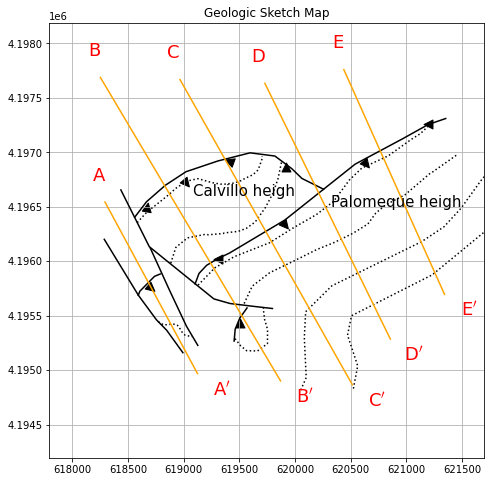

In [34]:
fig, ax = plt.subplots(1,figsize=(8,8))
for x in cont:
    ax.plot(x[0],x[1],color='black')
for x in cab:
    ax.plot(x[0],x[1],linestyle='dotted',color='black')
for x in fal:
    ax.plot(x[0],x[1],color='black')

t = mpl.markers.MarkerStyle(marker='>')
t._transform = t.get_transform().rotate_deg(80)
ax.scatter([calvillo[0][1]],
        [calvillo[1][1]-50],marker=t,s=80,c='black')

t = mpl.markers.MarkerStyle(marker='>')
t._transform = t.get_transform().rotate_deg(310)
ax.scatter([calvillo[0][3]],
        [calvillo[1][3]-100],marker=t,s=80,c='black')

t = mpl.markers.MarkerStyle(marker='v')
t._transform = t.get_transform().rotate_deg(250)
ax.scatter([calvillo[0][4]+100],
        [calvillo[1][4]],marker=t,s=80,c='black')

t = mpl.markers.MarkerStyle(marker='v')
t._transform = t.get_transform().rotate_deg(180)
ax.scatter([calvillo[0][6]+100],
        [calvillo[1][6]-100],marker=t,s=80,c='black')

t = mpl.markers.MarkerStyle(marker='v')
t._transform = t.get_transform().rotate_deg(50)
ax.scatter([calvillo_ds[0][1]-30],
        [calvillo_ds[1][1]-110],marker=t,s=80,c='black')

t = mpl.markers.MarkerStyle(marker='v')
t._transform = t.get_transform().rotate_deg(180)
ax.scatter([palomeque_ds[0][1]],
        [palomeque_ds[1][1]-50],marker=t,s=80,c='black')

t = mpl.markers.MarkerStyle(marker='>')
t._transform = t.get_transform().rotate_deg(180)
ax.scatter([palomeque[0][3]],
        [palomeque[1][3]],marker=t,s=80,c='black')

t = mpl.markers.MarkerStyle(marker='>')
t._transform = t.get_transform().rotate_deg(310)
ax.scatter([palomeque[0][5]],
        [palomeque[1][5]-50],marker=t,s=80,c='black')

t = mpl.markers.MarkerStyle(marker='v')
t._transform = t.get_transform().rotate_deg(40)
ax.scatter([palomeque[0][6]+100],
        [palomeque[1][6]],marker=t,s=80,c='black')

t = mpl.markers.MarkerStyle(marker='^')
t._transform = t.get_transform().rotate_deg(90)
ax.scatter([palomeque[0][8]],
        [palomeque[1][8]],marker=t,s=80,c='black')

ax.plot([secx[0],secx[1]],[secy[0],secy[1]],c='orange')
plt.text(secx[0], secy[0]+200, 'A', ha='right', fontsize=18,c='r')
plt.text(secx[1]+300, secy[1]-200, 'A$^\prime$', ha='right', fontsize=18,c='r')

ax.plot([secx[2],secx[3]],[secy[2],secy[3]],c='orange')
plt.text(secx[2], secy[2]+200, 'B', ha='right', fontsize=18,c='r')
plt.text(secx[3]+300, secy[3]-200, 'B$^\prime$', ha='right', fontsize=18,c='r')

ax.plot([secx[4],secx[5]],[secy[4],secy[5]],c='orange')
plt.text(secx[4], secy[4]+200, 'C', ha='right', fontsize=18,c='r')
plt.text(secx[5]+300, secy[5]-200, 'C$^\prime$', ha='right', fontsize=18,c='r')

ax.plot([secx[6],secx[7]],[secy[6],secy[7]],c='orange')
plt.text(secx[6], secy[6]+200, 'D', ha='right', fontsize=18,c='r')
plt.text(secx[7]+300, secy[7]-200, 'D$^\prime$', ha='right', fontsize=18,c='r')

ax.plot([secx[8],secx[9]],[secy[8],secy[9]],c='orange')
plt.text(secx[8], secy[8]+200, 'E', ha='right', fontsize=18,c='r')
plt.text(secx[9]+300, secy[9]-200, 'E$^\prime$', ha='right', fontsize=18,c='r')


ax.text(620000,4196600,'Calvillo heigh',ha='right', fontsize=15,c='black')
ax.text(621500,4196500,'Palomeque heigh',ha='right', fontsize=15,c='black')


plt.ylim((secy[9]-1500,secy[2]+500))
plt.xlim((secx[0]-500,621700))

#ax.plot([618000,618500,618500,618000,618000],[4195000,4195000,4194500,4194500,4195000])

ratio = 1.0
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)


ax.grid()
plt.title('Geologic Sketch Map')
plt.savefig(FIGURESDIR+'sketch_map.png',facecolor='white')


## Vertical geological cross-sections. 

The objetive now is to obtain the cross-sections given by five horizontal planes.

First we create: 
- A list `points` with the 3-D coordinates of the points: A, A$^\prime$, B, B$^\prime$, C, C$^\prime$, D, D$^\prime$ and E, E$^\prime$.
- The directions of the corresponding planes.
- The normalized vector of the directions.

In [35]:
points=[[(secx[i],secy[i],secelv[i]),secp[i]] for i in range(len(secx))]

In [36]:
# directions

d1=(secx[1]-secx[0],secy[1]-secy[0])
d2=(secx[3]-secx[2],secy[3]-secy[2])
d3=(secx[5]-secx[4],secy[5]-secy[4])
d4=(secx[7]-secx[6],secy[7]-secy[6])
d5=(secx[9]-secx[8],secy[9]-secy[8])

#normalization

d1n=(d1[0]/np.sqrt(d1[0]**2+d1[1]**2),d1[1]/np.sqrt(d1[0]**2+d1[1]**2))
d2n=(d2[0]/np.sqrt(d2[0]**2+d2[1]**2),d2[1]/np.sqrt(d2[0]**2+d2[1]**2))
d3n=(d3[0]/np.sqrt(d3[0]**2+d3[1]**2),d3[1]/np.sqrt(d3[0]**2+d3[1]**2))
d4n=(d4[0]/np.sqrt(d4[0]**2+d4[1]**2),d4[1]/np.sqrt(d4[0]**2+d4[1]**2))
d5n=(d5[0]/np.sqrt(d5[0]**2+d5[1]**2),d5[1]/np.sqrt(d5[0]**2+d5[1]**2))

The following <span style="color:blue">plane_3d</span> function uses the `Mesh3` command to create the data needed to construct a horizontal plane determined by two points.

In [37]:
def plane_3d(A0,A1,deep,nam,gr,t):
    x=[A0[0],A0[0],A1[0],A1[0]]
    y=[A0[1],A0[1],A1[1],A1[1]]
    z=[max(A0[2],A1[2])+100,deep,max(A0[2],A1[2])+100,deep]
    return go.Mesh3d(x=x,y=y,z=z,
                     delaunayaxis='y',
                     name=nam,
                     legendgroup=gr,
                     showlegend=t,
                     opacity=0.20,
                     color ="yellow")

In [38]:
p1=plane_3d(points[0][0],points[1][0],100,'sections','sections',True)
p2=plane_3d(points[2][0],points[3][0],100,'section '+points[2][1]+points[3][1],'B',True)
p3=plane_3d(points[4][0],points[5][0],100,'section '+points[4][1]+points[5][1],'C',True)
p4=plane_3d(points[6][0],points[7][0],100,'section '+points[6][1]+points[7][1],'D',True)
p5=plane_3d(points[8][0],points[9][0],100,'section '+points[8][1]+points[9][1],'E',True)

data_planes=[p1,p2,p3,p4,p5]

We need to determine the intersections of the planes with the tracks that give the geological items.

To compute those intersections we define the following mathematical funtions.

In [39]:
# The equation of the plane determined by three points, z in terms of x and y

def plane(p1,p2,p3,x,y):
    P1=np.array(p1)
    P2=np.array(p2)
    P3=np.array(p3)
    v1 = P3 - P1
    v2 = P2 - P1
    cp = np.cross(v1, v2)
    a, b, c = cp
    d = np.dot(cp, P3)
    if c!=0:
        return [True,(d - a * x - b * y) / c ] 
    else:
        return [False, a*x+b*y-d]

# The equation of the plane determined by three points, y in terms of x and z

def plane_y(p1,p2,p3,x,z):
    P1=np.array(p1)
    P2=np.array(p2)
    P3=np.array(p3)
    v1 = P3 - P1
    v2 = P2 - P1
    cp = np.cross(v1, v2)
    a, b, c = cp
    d = np.dot(cp, P3)
    if b!=0:
        return [True,(d - a * x - c * z) / b ] 
    else:
        return [False, a*x+c*z-d]

# Implicit equation of the line determined by two points, y and z in terms of x 

def impl_line(p1,p2,x):
    P1=np.array(p1)
    P2=np.array(p2)
    v = P2 - P1
    y=((x-P1[0])/v[0])*v[1]+P1[1]
    z=((x-P1[0])/v[0])*v[2]+P1[2]
    return [x,y,z] 

#  parametric equation of the line determined by two points

def para_line(p1,p2):
    P1=np.array(p1)
    P2=np.array(p2)
    v = P2 - P1
    g = lambda t: [P1[0]+v[0]*t,P1[1]+v[1]*t,P1[2]+v[2]*t]
    return g

# the intersection of a line with a plane

def inter_line_plane(p1,p2,q1,q2,q3):
    r=para_line(p1,p2)
    g= lambda t:list(map(r,[t]))[0]
    x,y,z=list(map(g, [t]))[0]
    p=plane(q1,q2,q3,x,y)
    if p[0]==False:
        l=solve(p[1],t)
        sol=list(map(g,l))[0]
        return  [float(x) for x in sol]
    else:
        l=solve(z-p[1],t)
        sol=list(map(g,l))[0]
        return [float(x) for x in sol]

In [40]:
t = Symbol('t')

# Intersections of plane A-A' with the tracks for thrusts and stratigraphic contacts 

a01=[points[0][0],points[1][0],(points[0][0][0],points[0][0][1],100)]

# calvillo ds th

cds1_A=[calvillo_ds[0][3],calvillo_ds[1][3],calvillo_ds[2][3]]
cds2_A=[calvillo_ds[0][2],calvillo_ds[1][2],calvillo_ds[2][2]]

int_Cal_ds_A=inter_line_plane(cds1_A,cds2_A,a01[0],a01[1],a01[2])

int_Cal_ds_A[2]=int_Cal_ds_A[2]-15

#E12 calvillo ds

e12cds1_A=[E12cal_ds[0][-12],E12cal_ds[1][-12],E12cal_ds[2][-12]]
e12cds2_A=[E12cal_ds[0][-13],E12cal_ds[1][-13],E12cal_ds[2][-13]]

int_e12cds_A=inter_line_plane(e12cds1_A,e12cds2_A,a01[0],a01[1],a01[2])


In [41]:
t = Symbol('t')

# Intersections of plane B-B' with the tracks for fault, thrusts and stratigraphic contacts 

b01=[points[2][0],points[3][0],(points[2][0][0],points[2][0][1],100)]

# with palomeque

pt1_B=[palomeque[0][2],palomeque[1][2],palomeque[2][2]]
pt2_B=[palomeque[0][3],palomeque[1][3],palomeque[2][3]]
int_Pal_th_B=inter_line_plane(pt1_B,pt2_B,b01[0],b01[1],b01[2])

# with calvillo

ct1_B=[calvillo[0][2],calvillo[1][2],calvillo[2][2]]
ct2_B=[calvillo[0][1],calvillo[1][1],calvillo[2][1]]
int_Cal_th_B=inter_line_plane(ct1_B,ct2_B,b01[0],b01[1],b01[2])

# with palomeque ds

pd1_B=[palomeque_ds[0][2],palomeque_ds[1][2],palomeque_ds[2][2]]
pd2_B=[palomeque_ds[0][1],palomeque_ds[1][1],palomeque_ds[2][1]]
int_Pal_ds_B=inter_line_plane(pd1_B,pd2_B,b01[0],b01[1],b01[2])

# with  fault1

f11=[fault1[0][2],fault1[1][2],fault1[2][2]]
f12=[fault1[0][3],fault1[1][3],fault1[2][3]]
int_F1_B=inter_line_plane(f11,f12,b01[0],b01[1],b01[2])

int_F1_B_s=[int_F1_B[0],int_F1_B[1],100]

#E12 with calvillo

e12c1_B=[E12cal[0][2],E12cal[1][2],E12cal[2][2]]
e12c2_B=[E12cal[0][3],E12cal[1][3],E12cal[2][3]]

int_e12c_B=inter_line_plane(e12c1_B,e12c2_B,b01[0],b01[1],b01[2])


#PE with palomeque

pep1_B=[PEpal[0][0],PEpal[1][0],PEpal[2][0]]
pep2_B=[PEpal[0][1],PEpal[1][1],PEpal[2][1]]

int_pep_B=inter_line_plane(pep1_B,pep2_B,b01[0],b01[1],b01[2])

#PE with calvillo

pec1_B=[PEcal[0][2],PEcal[1][2],PEcal[2][2]]
pec2_B=[PEcal[0][3],PEcal[1][3],PEcal[2][3]]

int_pec_B=inter_line_plane(pec1_B,pec2_B,b01[0],b01[1],b01[2])

In [42]:
t = Symbol('t')

# Intersections of plane C-C' with the tracks for fault, thrusts and stratigraphic contacts 

c01=[points[4][0],points[5][0],(points[4][0][0],points[4][0][1],100)]

ct1_C=[calvillo[0][5],calvillo[1][5],calvillo[2][5]]
ct2_C=[calvillo[0][4],calvillo[1][4],calvillo[2][4]]

int_Cal_th_C=inter_line_plane(ct1_C,ct2_C,c01[0],c01[1],c01[2])

pt1_C=[palomeque[0][4],palomeque[1][4],palomeque[2][4]]
pt2_C=[palomeque[0][5],palomeque[1][5],palomeque[2][5]]

int_Pal_th_C=inter_line_plane(pt1_C,pt2_C,c01[0],c01[1],c01[2])

# with falla1

f13=[fault1[0][-1],fault1[1][-1],fault1[2][-1]]
f14=[fault1[0][-2],fault1[1][-2],fault1[2][-2]]
int_F1_C=inter_line_plane(f13,f14,c01[0],c01[1],c01[2])

#PE with calvillo

pec1_C=[PEcal[0][18],PEcal[1][18],PEcal[2][18]]
pec2_C=[PEcal[0][17],PEcal[1][17],PEcal[2][17]]

int_pec_C=inter_line_plane(pec1_C,pec2_C,c01[0],c01[1],c01[2])

#E12 with calvillo

e12c1_C=[E12cal[0][-4],E12cal[1][-4],E12cal[2][-4]]
e12c2_C=[E12cal[0][-5],E12cal[1][-5],E12cal[2][-5]]

int_e12c_C=inter_line_plane(e12c1_C,e12c2_C,c01[0],c01[1],c01[2])


#PE with palomeque

pep1_C=[PEpal[0][3],PEpal[1][3],PEpal[2][3]]
pep2_C=[PEpal[0][4],PEpal[1][4],PEpal[2][4]]

int_pep_C=inter_line_plane(pep1_C,pep2_C,c01[0],c01[1],c01[2])


#E12 with palomeque

e12p1_C=[E12pal[0][3],E12pal[1][3],E12pal[2][3]]
e12p2_C=[E12pal[0][2],E12pal[1][2],E12pal[2][2]]

int_e12p_C=inter_line_plane(e12p1_C,e12p2_C,c01[0],c01[1],c01[2])

#E23 with palomeque

e23p1_C=[E23pal[0][3],E23pal[1][3],E23pal[2][3]]
e23p2_C=[E23pal[0][4],E23pal[1][4],E23pal[2][4]]

int_e23p_C=inter_line_plane(e23p1_C,e23p2_C,c01[0],c01[1],c01[2])

In [43]:
t = Symbol('t')

# Intersections of plane D-D' with the tracks for fault, thrusts and stratigraphic contacts 

d01=[points[6][0],points[7][0],(points[6][0][0],points[6][0][1],100)]

ct1_D=[calvillo[0][-1],calvillo[1][-1],calvillo[2][-1]]
ct2_D=[calvillo[0][-2],calvillo[1][-2],calvillo[2][-2]]

int_Cal_th_D=inter_line_plane(ct1_D,ct2_D,d01[0],d01[1],d01[2])

pt1_D=[palomeque[0][-4],palomeque[1][-4],palomeque[2][-4]]
pt2_D=[palomeque[0][-5],palomeque[1][-5],palomeque[2][-5]]

int_Pal_th_D=inter_line_plane(pt1_D,pt2_D,d01[0],d01[1],d01[2])

#PE with palomeque

pep1_D=[PEpal[0][6],PEpal[1][6],PEpal[2][6]]
pep2_D=[PEpal[0][5],PEpal[1][5],PEpal[2][5]]

int_pep_D=inter_line_plane(pep1_D,pep2_D,d01[0],d01[1],d01[2])

#E12 with palomeque

e12p1_D=[E12pal[0][5],E12pal[1][5],E12pal[2][5]]
e12p2_D=[E12pal[0][6],E12pal[1][6],E12pal[2][6]]

int_e12p_D=inter_line_plane(e12p1_D,e12p2_D,d01[0],d01[1],d01[2])

#E23 with palomeque

e23p1_D=[E23pal[0][4],E23pal[1][4],E23pal[2][4]]
e23p2_D=[E23pal[0][5],E23pal[1][5],E23pal[2][5]]

int_e23p_D=inter_line_plane(e23p1_D,e23p2_D,d01[0],d01[1],d01[2])

# E3O with palomeque
e3op1_D=[E3Opal[0][-5],E3Opal[1][-5],E3Opal[2][-5]]
e3op2_D=[E3Opal[0][-6],E3Opal[1][-6],E3Opal[2][-6]]

int_e3op_D=inter_line_plane(e3op1_D,e3op2_D,d01[0],d01[1],d01[2])

In [44]:
t = Symbol('t')

# Intersections of plane E-E' with the tracks for fault, thrusts and stratigraphic contacts 

e01=[points[8][0],points[9][0],(points[8][0][0],points[8][0][1],100)]

# Palomeque th

pt1_E=[palomeque[0][-3],palomeque[1][-3],palomeque[2][-3]]
pt2_E=[palomeque[0][-4],palomeque[1][-4],palomeque[2][-4]]

int_Pal_th_E=inter_line_plane(pt1_E,pt2_E,e01[0],e01[1],e01[2])


#PE palomeque

pep1_E=[PEpal[0][-5],PEpal[1][-5],PEpal[2][-5]]
pep2_E=[PEpal[0][-4],PEpal[1][-4],PEpal[2][-4]]

int_pep_E=inter_line_plane(pep1_E,pep2_E,e01[0],e01[1],e01[2])


#E12 palomeque

e12p1_E=[E12pal[0][-6],E12pal[1][-6],E12pal[2][-6]]
e12p2_E=[E12pal[0][-5],E12pal[1][-5],E12pal[2][-5]]

int_e12p_E=inter_line_plane(e12p1_E,e12p2_E,e01[0],e01[1],e01[2])


#E23 palomeque

e23p1_E=[E23pal[0][-9],E23pal[1][-9],E23pal[2][-9]]
e23p2_E=[E23pal[0][-8],E23pal[1][-8],E23pal[2][-8]]

int_e23p_E=inter_line_plane(e23p1_E,e23p2_E,e01[0],e01[1],e01[2])

# E3O palomeque
e3op1_E=[E3Opal[0][-5],E3Opal[1][-5],E3Opal[2][-5]]
e3op2_E=[E3Opal[0][-6],E3Opal[1][-6],E3Opal[2][-6]]

int_e3op_E=inter_line_plane(e3op1_E,e3op2_E,e01[0],e01[1],e01[2])

We have to represent the intersections of the topography and the sections in the corresponding planes, for that we have to do some calculations

In [45]:
# Topography A-A'

Atopot=[np.sqrt(Atopox[i]**2+Atopoy[i]**2) for i in range(len(Atopox))]

Atopo_gr=[topox,topoy,topoelv]

cot_A=[min(Atopox),max(Atopox),min(Atopoelv),max(Atopoelv)]

arA=600/(Atopot[0]-Atopot[-1])

In [46]:
# Topography B-B'

Btopot=[np.sqrt(Btopox[i]**2+Btopoy[i]**2) for i in range(len(Btopox))]


Btopo_gr=[Btopox,Btopoy,Btopoelv]

cot_B=[min(Btopox),max(Btopox),min(Btopoelv),max(Btopoelv)]

arB=600/(Btopot[0]-Btopot[-1])

In [47]:
# Topography C-C'

Ctopot=[np.sqrt(Ctopox[i]**2+Ctopoy[i]**2) for i in range(len(Ctopox))]


Ctopo_gr=[Ctopox,Ctopoy,Ctopoelv]

cot_C=[min(Ctopox),max(Ctopox),min(Ctopoelv),max(Ctopoelv)]

arC=600/(Ctopot[0]-Ctopot[-1])

In [48]:
# Topography D-D'

Dtopot=[np.sqrt(Dtopox[i]**2+Dtopoy[i]**2) for i in range(len(Dtopox))]


Dtopo_gr=[Dtopox,Dtopoy,Dtopoelv]

cot_D=[min(Dtopox),max(Dtopox),min(Dtopoelv),max(Dtopoelv)]

arD=600/(Dtopot[0]-Dtopot[-1])

In [49]:
# Topography E-E'

Etopot=[np.sqrt(Etopox[i]**2+Etopoy[i]**2) for i in range(len(Etopox))]


Etopo_gr=[Etopox,Etopoy,Etopoelv]

cot_E=[min(Etopox),max(Etopox),min(Etopoelv),max(Etopoelv)]

arE=600/(Etopot[0]-Etopot[-1])

### Curvas de Bezier

https://github.com/torresjrjr/Bezier.py

In [50]:
from Bezier import Bezier

t_points = np.arange(0, 1, 0.01) # Creates an iterable list from 0 to 1.

def bz(punto, direc, lista_intervalos,lista_alturas,punto_fin):
    if punto_fin==[]:
        c=[punto]+[[punto[0]+direc[0]*lista_intervalos[i],
                punto[1]+direc[1]*lista_intervalos[i],
                lista_alturas[i]] for i in range(len(lista_intervalos))]
    else:
        c=c=[punto]+[[punto[0]+direc[0]*lista_intervalos[i],
                punto[1]+direc[1]*lista_intervalos[i],
                lista_alturas[i]] for i in range(len(lista_intervalos))]+[punto_fin]
    xc=[x[0] for x in c]
    yc=[x[1] for x in c]
    zc=[x[2] for x in c]
    c_Bz=[[xc[i], zc[i]] for i in range(len(xc))]
    npc_Bz=np.array(c_Bz)
    c1_Bz= Bezier.Curve(t_points,npc_Bz) 
    x1=[x[0] for x in c1_Bz]
    z1=[x[1] for x in c1_Bz]
    y1=[plane_y(c[0],c[1],c[2],x1[i],z1[i])[1] for i in range(len(x1))]
    t1=[np.sqrt(x1[i]**2+y1[i]**2) for i in range(len(x1))]
    return [x1,y1,z1,npc_Bz,t1]  

## Section A-A'

In [51]:
calds_A=bz(int_Cal_ds_A,d1n,
           [100,200,350,480],[500,450,310,300],[])


cpds_A=bz([calds_A[0][15],calds_A[1][15],calds_A[2][15]],d1n,
          [250,270,400,800,1500],[600,550,400,350,300],[])

peds_A=bz([calds_A[0][6],calds_A[1][6],calds_A[2][6]],d1n,
          [250,270,400,800,1500],[700,670,550,450,400],
          [])

e1e2_A=bz(int_e12cds_A,d1n,
          [250,270,400,800],[620,620,510,570],[])


om_A=bz([calds_A[0][24],calds_A[1][24],calds_A[2][24]],d3n,[-150,-200,-1100],[300,400,500],[])

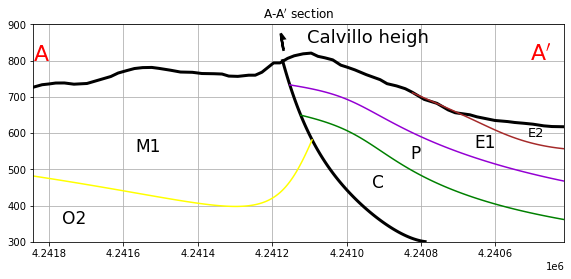

In [52]:
w, h = plt.figaspect(arA)

fig, ax = plt.subplots(figsize=(w,h))
plt.plot(Atopot,Atopoelv,color='black',linewidth=3)


ax.plot(calds_A[4], calds_A[2], color='black',linewidth=3, alpha=1.00)
ax.plot(cpds_A[4], cpds_A[2], color='green', alpha=1.00)

ax.plot(peds_A[4], peds_A[2], color='darkviolet', alpha=1.00)
ax.plot(e1e2_A[4], e1e2_A[2], color='brown', alpha=1.00)
ax.plot(om_A[4], om_A[2], color='yellow', alpha=1.00)



tick_spacing=100
ax.xaxis.set_major_locator(ticker.MultipleLocator(2*tick_spacing))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))


plt.arrow(4241170, 830, 5, 30, shape='right', head_width=15, head_length=15,linewidth=2.5)


t=('Calvillo heigh')
M1=('M1')
O2=('O2')
C=('C')
P=('P')
E1=('E1')
E2=('E2')
A=('A')
AA=('A$^\prime$')

plt.text(4240780, 850, t, ha='right', fontsize=18,rotation=0, wrap=True)
plt.text(4241700, 350, O2, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4241500, 550, M1, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4240900, 450, C, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4240800, 530, P, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4240600, 560, E1, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4240470, 590, E2, ha='right', fontsize=13,rotation=0, wrap=True)
plt.text(4241800, 800, A, ha='right', fontsize=22,color='red',rotation=0, wrap=True)
plt.text(4240450, 800, AA, ha='right', fontsize=22,color='red',rotation=0, wrap=True)


plt.ylim((300,900))
plt.xlim((Atopot[0],Atopot[-1]))
plt.grid()
plt.title('A-A$^\prime$ section')

plt.savefig(FIGURESDIR+'sectionA.png',facecolor='white',bbox_inches='tight')

plt.show()

## Section B-B'

In [53]:
fBt=np.sqrt(int_F1_B[0]**2+int_F1_B[1]**2)
faln_B=[[fBt,fBt],[int_F1_B[2]-5,100]]

cal_B=bz(int_Cal_th_B,d2n,[100,150,200,250,380,560],
                          [600,570,480,420,370,300],[])
pal_B=bz(int_Pal_th_B,d2n,[100,150,200],
                          [500,490,400],[int_F1_B[0],int_F1_B[1],300])
pal_ds_B=bz(int_Pal_ds_B,d2n,[100,150,200,350],
                             [500,400,350,300],[])
om_B=bz([cal_B[0][37],cal_B[1][37],cal_B[2][37]],d2n,[-150,-200,-1300],[300,400,500],[])







cp1_B=bz([cal_B[0][10],cal_B[1][10],cal_B[2][10]],d2n,
         [200,510,660],[650,420,350],
         [pal_B[0][63],pal_B[1][63],pal_B[2][63]])
cp2_Bn=bz([pal_B[0][11],pal_B[1][11],pal_B[2][11]],d2n,
         [100,170,250],[640,600,520],
         [int_F1_B[0],int_F1_B[1],550])
cp3_B=bz([int_F1_B[0],int_F1_B[1],450],d2n,
         [100,280],[400,390],
         [pal_ds_B[0][40],pal_ds_B[1][40],pal_ds_B[2][40]])
cp4_Bn=bz([pal_ds_B[0][40],pal_ds_B[1][40],pal_ds_B[2][40]],d2n,
         [100,500,590,1000],[520,300,290,430],[])


pe1_Bn=bz(int_pec_B,d2n,
         [400,650],[640,450],
         [pal_B[0][30],pal_B[1][30],pal_B[2][30]])
pe2_B=bz(int_pep_B,d2n,
         [100,200,280],[730,680,650],
         [int_F1_B[0],int_F1_B[1],650])
pe3_B=bz([int_F1_B[0],int_F1_B[1],550],d2n,
         [100,200],[500,490],
         [pal_ds_B[0][20],pal_ds_B[1][20],pal_ds_B[2][20]])
pe4_Bn=bz([pal_ds_B[0][17],pal_ds_B[1][17],pal_ds_B[2][17]],d2n,
         [100,500,530,590],[650,450,460,470],[])


e1e21_B=bz(int_e12c_B,d2n,
           [200,300],[620,580],
           [pal_B[0][11],pal_B[1][11],pal_B[2][11]])
e1e22_Bn=bz([int_F1_B[0],int_F1_B[1],650],
           d2n,[100],[600],
           [pal_ds_B[0][6],pal_ds_B[1][6],pal_ds_B[2][6]])
e1e23_B=bz([Btopox[-6],Btopoy[-6],Btopoelv[-8]-10],d2n,
           [200,250],[550,560],[])



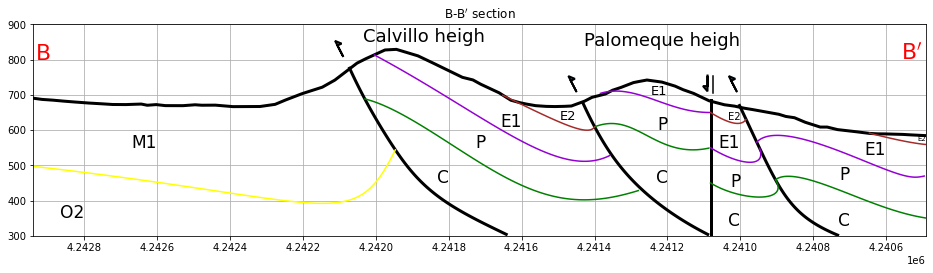

In [54]:
w, h = plt.figaspect(arB)

fig, ax = plt.subplots(figsize=(w,h))

plt.plot(Btopot,Btopoelv,color='black',linewidth=3)


ax.plot(faln_B[0], faln_B[1], color='black', alpha=1.00,linewidth=3)

ax.plot(cal_B[4], cal_B[2], color='black', alpha=1.00,linewidth=3)
ax.plot(pal_B[4], pal_B[2], color='black', alpha=1.00,linewidth=3)
ax.plot(pal_ds_B[4], pal_ds_B[2], color='black', alpha=1.00,linewidth=3)
ax.plot(om_B[4], om_B[2], color='yellow', alpha=1.00)

ax.plot(cp1_B[4], cp1_B[2], color='green', alpha=1.00)
ax.plot(cp2_Bn[4], cp2_Bn[2], color='green', alpha=1.00)
ax.plot(cp3_B[4], cp3_B[2], color='green', alpha=1.00)
ax.plot(cp4_Bn[4], cp4_Bn[2], color='green', alpha=1.00)



ax.plot(pe1_Bn[4], pe1_Bn[2], color='darkviolet', alpha=1.00)
ax.plot(pe2_B[4], pe2_B[2], color='darkviolet', alpha=1.00)
ax.plot(pe3_B[4], pe3_B[2], color='darkviolet', alpha=1.00)
ax.plot(pe4_Bn[4], pe4_Bn[2], color='darkviolet', alpha=1.00)



ax.plot(e1e21_B[4], e1e21_B[2], color='brown', alpha=1.00)
ax.plot(e1e22_Bn[4], e1e22_Bn[2], color='brown', alpha=1.00)
ax.plot(e1e23_B[4], e1e23_B[2], color='brown', alpha=1.00)



t1=('Calvillo heigh')
t2=('Palomeque heigh')
M1=('M1')
O2=('O2')
C=('C')
P=('P')
E1=('E1')
E2=('E2')
B=('B')
BB=('B$^\prime$')

plt.text(4241700, 850, t1, ha='right', fontsize=18,rotation=0, wrap=True)
plt.text(4241000, 840, t2, ha='right', fontsize=18,rotation=0, wrap=True)

plt.text(4242800, 350, O2, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4242600, 550, M1, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4241800, 450, C, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4241200, 450, C, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4241000, 330, C, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4240700, 330, C, ha='right', fontsize=17,rotation=0, wrap=True)


plt.text(4241700, 550, P, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4241200, 600, P, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4241000, 440, P, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4240700, 460, P, ha='right', fontsize=17,rotation=0, wrap=True)


plt.text(4241600, 610, E1, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4241200, 700, E1, ha='right', fontsize=13,rotation=0, wrap=True)
plt.text(4241000, 550, E1, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4240600, 530, E1, ha='right', fontsize=17,rotation=0, wrap=True)


plt.text(4241450, 630, E2, ha='right', fontsize=13,rotation=0, wrap=True)
plt.text(4241000, 630, E2, ha='right', fontsize=10,rotation=0, wrap=True)
plt.text(4240490, 570, E2, ha='right', fontsize=7,rotation=0, wrap=True)


plt.text(4242890, 800, B, ha='right', fontsize=22,color='red',rotation=0, wrap=True)
plt.text(4240500, 800, BB, ha='right', fontsize=22,color='red',rotation=0, wrap=True)

plt.arrow(4242090, 810, 15, 30, shape='right', head_width=25, head_length=15,linewidth=2)
plt.arrow(4241450, 710, 15, 30, shape='right', head_width=25, head_length=15,linewidth=2)
plt.arrow(4241010, 710, 15, 30, shape='right', head_width=25, head_length=15,linewidth=2)
plt.arrow(4241090, 755, 0, -30, shape='right', head_width=25, head_length=15,linewidth=2)
ax.plot([4241075,4241075],[755,705],color='black')


tick_spacing=100
ax.xaxis.set_major_locator(ticker.MultipleLocator(2*tick_spacing))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#plt.xticks([])

plt.ylim((300,900))
plt.xlim((Btopot[0]-20,Btopot[-1]))


plt.grid()
plt.title('B-B$^\prime$ section')

plt.savefig(FIGURESDIR+'sectionB.png',facecolor='white',bbox_inches='tight')

plt.show()

## Corte C-C'

In [55]:
cal_C=bz(int_Cal_th_C,d3n,[100,200,350,450],[550,400,310,300],[])
pal_C=bz(int_Pal_th_C,d3n,[100,200,350,450],[520,370,310,300],[])
om_C=bz([cal_C[0][27],cal_C[1][27],cal_C[2][27]],d3n,
        [-150,-200,-1000],[300,400,500],[])


cp1_Cn=bz([cal_C[0][12],cal_C[1][12],cal_C[2][12]],d3n,
         [300,510,660],[700,450,250],
         #[250,500,600,950],[790,380,250,200],
         [pal_C[0][43],pal_C[1][43],pal_C[2][43]])
cp2_Cn=bz([pal_C[0][12],pal_C[1][12],pal_C[2][12]],d3n,
         [100,400,850],[650,320,290],
         [])


pe1_Cn=bz(int_pec_C,d3n,
         [200,400,550],[650,570,390],
         [pal_C[0][24],pal_C[1][24],pal_C[2][24]])
pe2_Cn=bz(int_pep_C,d3n,[400,500,1100,1300,1400,1500],
          [500,390,310,320,400,340],[])


e1e21_C=bz(int_e12c_C,d3n,
           [100,200],[600,550],
           [pal_C[0][10],pal_C[1][10],pal_C[2][10]])
e1e21_Cn=bz(int_e12c_C,d3n,
           [100,200],[600,550],
           [pal_C[0][10],pal_C[1][10],pal_C[2][10]])
e1e22_Cn=bz([int_e12p_C[0],int_e12p_C[1],int_e12p_C[2]+8],d3n,
           [200,350,900,1200,1300],[600,500,350,530,430],[])

e2e3_Cn=bz(int_e23p_C,d3n,[200,350,800,830],[570,480,630,525],[])

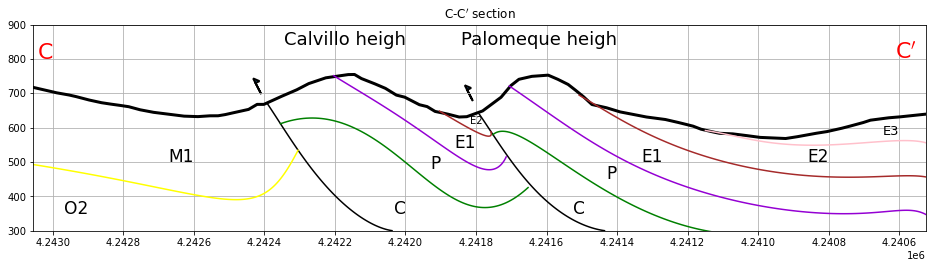

In [56]:
w, h = plt.figaspect(arC)

fig, ax = plt.subplots(figsize=(w,h))

plt.plot(Ctopot,Ctopoelv,color='black',linewidth=3)

ax.plot(cal_C[4], cal_C[2], color='black', alpha=1.00)
ax.plot(pal_C[4],pal_C[2], color='black', alpha=1.00)
ax.plot(om_C[4],om_C[2], color='yellow', alpha=1.00)


ax.plot(cp1_Cn[4], cp1_Cn[2], color='green', alpha=1.00)
ax.plot(cp2_Cn[4], cp2_Cn[2], color='green', alpha=1.00)


ax.plot(pe1_Cn[4], pe1_Cn[2], color='darkviolet', alpha=1.00)
ax.plot(pe2_Cn[4], pe2_Cn[2], color='darkviolet', alpha=1.00)

ax.plot(e1e21_C[4], e1e21_C[2], color='brown', alpha=1.00)
ax.plot(e1e22_Cn[4], e1e22_Cn[2], color='brown', alpha=1.00)

ax.plot(e2e3_Cn[4], e2e3_Cn[2], color='pink', alpha=1.00)

t1=('Calvillo heigh')
t2=('Palomeque heigh')
M1=('M1')
O2=('O2')
C=('C')
P=('P')
E1=('E1')
E2=('E2')
E3=('E3')
C_1=('C')
CC_1=('C$^\prime$')

plt.text(4242000, 840, t1, ha='right', fontsize=18,rotation=0, wrap=True)
plt.text(4241400, 840, t2, ha='right', fontsize=18,rotation=0, wrap=True)

plt.text(4242900, 350, O2, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4242600, 500, M1, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4242000, 350, C, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4241490, 350, C, ha='right', fontsize=17,rotation=0, wrap=True)


plt.text(4241900, 480, P, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4241400, 450, P, ha='right', fontsize=17,rotation=0, wrap=True)

plt.text(4241800, 540, E1, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4241270, 500, E1, ha='right', fontsize=17,rotation=0, wrap=True)

plt.text(4241780, 610, E2, ha='right', fontsize=10,rotation=0, wrap=True)
plt.text(4240800, 500, E2, ha='right', fontsize=17,rotation=0, wrap=True)

plt.text(4240600, 580, E3, ha='right', fontsize=13,rotation=0, wrap=True)

plt.text(4243000, 800, C_1, ha='right', fontsize=22,color='red',rotation=0, wrap=True)
plt.text(4240550, 800, CC_1, ha='right', fontsize=22,color='red',rotation=0, wrap=True)


plt.arrow(4242410, 700, 15, 30, shape='right', head_width=25, head_length=15,linewidth=2)
plt.arrow(4241810, 680, 15, 30, shape='right', head_width=25, head_length=15,linewidth=2)

tick_spacing=100
ax.xaxis.set_major_locator(ticker.MultipleLocator(2*tick_spacing))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#plt.xticks([])

plt.ylim((300,900))
plt.xlim((Ctopot[0],Ctopot[-1]))


plt.grid()
plt.title('C-C$^\prime$ section')

plt.savefig(FIGURESDIR+'sectionC.png',facecolor='white',bbox_inches='tight')

plt.show()

## Section D-D'

In [57]:
cal_D=bz(int_Cal_th_D,d4n,[100,300,450,550],[500,300,350,290],[])
pal_D=bz(int_Pal_th_D,d4n,[100,200,350,450],[500,300,350,300],[])
om_D=bz([cal_D[0][16],cal_D[1][16],cal_D[2][16]],d3n,
        [-150,-200,-900],[300,400,500],[])


cp1_Dn=bz([pal_D[0][1],pal_D[1][1],pal_D[2][1]],d4n,
         [230,270,500,700,850],[670,500,400,310,300],[])

pe0_Dn=bz([cal_D[0][17],cal_D[1][17],cal_D[2][17]],d4n,
         [40],[460],[pal_D[0][17],pal_D[1][17],pal_D[2][17]])
pe1_Dn=bz(int_pep_D,d4n,
         [250,270,500,800,1500],[710,520,440,300,330],[])

e1e20_D=bz([cal_D[0][5],cal_D[1][5],cal_D[2][5]],d4n,
           [60],[560],[pal_D[0][5],pal_D[1][5],pal_D[2][5]])
e1e21_Dn=bz(int_e12p_D,d4n,
           [250,270,500,800,1300],[580,440,460,380,420],[])


e2e3_Dn=bz([int_e23p_D[0],int_e23p_D[1],int_e23p_D[2]-20],d4n,
          [250,270,500,940],[500,510,500,490],[])


e3eO_D=bz(int_e3op_D,d4n,[250,270,600],[550,560,570],[])


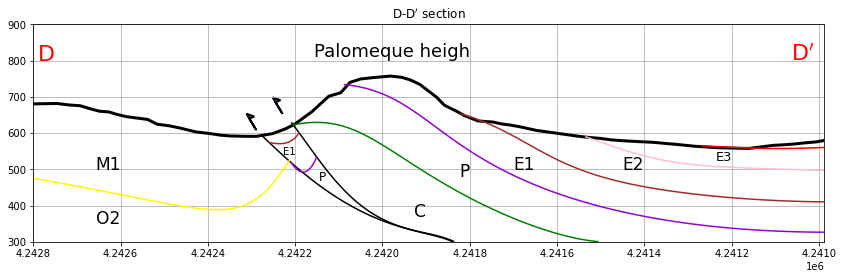

In [58]:
w, h = plt.figaspect(arD)

fig, ax = plt.subplots(figsize=(w,h))

plt.plot(Dtopot,Dtopoelv,color='black',linewidth=3)

ax.plot(cal_D[4], cal_D[2], color='black', alpha=1.00)
ax.plot(pal_D[4], pal_D[2], color='black', alpha=1.00)
ax.plot(om_D[4], om_D[2], color='yellow', alpha=1.00)

ax.plot(cp1_Dn[4], cp1_Dn[2], color='green', alpha=1.00)

ax.plot(pe0_Dn[4], pe0_Dn[2], color='darkviolet', alpha=1.00)
ax.plot(pe1_Dn[4], pe1_Dn[2], color='darkviolet', alpha=1.00)

ax.plot(e1e20_D[4], e1e20_D[2], color='brown', alpha=1.00)
ax.plot(e1e21_Dn[4], e1e21_Dn[2], color='brown', alpha=1.00)

ax.plot(e2e3_Dn[4], e2e3_Dn[2], color='pink', alpha=1.00)

ax.plot(e3eO_D[4], e3eO_D[2], color='r', alpha=1)

t1=('Calvillo heigh')
t2=('Palomeque heigh')
M1=('M1')
O2=('O2')
C=('C')
P=('P')
E1=('E1')
E2=('E2')
E3=('E3')
D=('D')
DD=('D$^\prime$')


plt.text(4241800, 810, t2, ha='right', fontsize=18,rotation=0, wrap=True)

plt.text(4242600, 350, O2, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4242600, 500, M1, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4241900, 370, C, ha='right', fontsize=17,rotation=0, wrap=True)


plt.text(4242130, 470, P, ha='right', fontsize=12,rotation=0, wrap=True)
plt.text(4241800, 480, P, ha='right', fontsize=17,rotation=0, wrap=True)

plt.text(4242200, 540, E1, ha='right', fontsize=10,rotation=0, wrap=True)
plt.text(4241650, 500, E1, ha='right', fontsize=17,rotation=0, wrap=True)

plt.text(4241400, 500, E2, ha='right', fontsize=17,rotation=0, wrap=True)

plt.text(4241200, 523, E3, ha='right', fontsize=13,rotation=0, wrap=True)

plt.text(4242750, 800, D, ha='right', fontsize=22,color='red',rotation=0, wrap=True)
plt.text(4241010, 800, DD, ha='right', fontsize=22,color='red',rotation=0, wrap=True)


plt.arrow(4242290, 610, 15, 30, shape='right', head_width=25, head_length=15,linewidth=2)
plt.arrow(4242230, 655, 15, 30, shape='right', head_width=25, head_length=15,linewidth=2)



tick_spacing=100
ax.xaxis.set_major_locator(ticker.MultipleLocator(2*tick_spacing))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#plt.xticks([])

plt.ylim((300,900))
plt.xlim((4242800,Dtopot[-1]))


plt.grid()
plt.title('D-D$^\prime$ section')

plt.savefig(FIGURESDIR+'sectionD.png',facecolor='white',bbox_inches='tight')

plt.show()

## Section E-E'

In [59]:
pal_E=bz(int_Pal_th_E,d5n,[100,200,450],[500,400,300],[])
om_E=bz([pal_E[0][22],pal_E[1][22],pal_E[2][22]],d3n,
        [-150,-200,-900],[300,400,500],[])


cp_En=bz([pal_E[0][22],pal_E[1][22],pal_E[2][22]],d5n,
        [300,400,550,700],[600,450,350,300],[])

pep_En=bz(int_pep_E,d5n,
         [250,270,430,600,800,1000],[680,670,560,490,350,300],[])

e1e2_En=bz(int_e12p_E,d5n,
          [260,260,300,500,700,800,1000],[600,580,500,440,400,320,360],[])

e2e3_E=bz(int_e23p_E,d5n,[150,100,400,900],[500,560,410,500],[])

e3eO_E=bz(int_e3op_E,d5n,[250,270],[500,540],[])

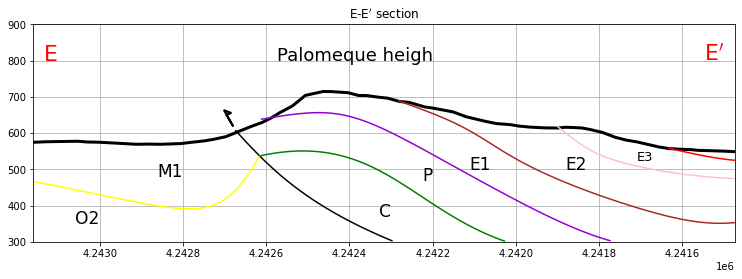

In [60]:
w, h = plt.figaspect(arE)

fig, ax = plt.subplots(figsize=(w,h))

plt.plot(Etopot,Etopoelv,color='black',linewidth=3)

ax.plot(pal_E[4], pal_E[2], color='black', alpha=1.00)
ax.plot(om_E[4], om_E[2], color='yellow', alpha=1.00)

ax.plot(cp_En[4], cp_En[2], color='green', alpha=1.00)

ax.plot(pep_En[4], pep_En[2], color='darkviolet', alpha=1.00)

ax.plot(e1e2_En[4], e1e2_En[2], color='brown', alpha=1.00)

ax.plot(e2e3_E[4], e2e3_E[2], color='pink', alpha=1.00)
ax.plot(e3eO_E[4], e3eO_E[2], color='r', alpha=1.00)

t1=('Calvillo heigh')
t2=('Palomeque heigh')
M1=('M1')
O2=('O2')
C=('C')
P=('P')
E1=('E1')
E2=('E2')
E3=('E3')
E=('E')
EE=('E$^\prime$')


plt.text(4242200, 800, t2, ha='right', fontsize=18,rotation=0, wrap=True)

plt.text(4243000, 350, O2, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4242800, 480, M1, ha='right', fontsize=17,rotation=0, wrap=True)
plt.text(4242300, 370, C, ha='right', fontsize=17,rotation=0, wrap=True)


plt.text(4242200, 470, P, ha='right', fontsize=17,rotation=0, wrap=True)

plt.text(4242060, 500, E1, ha='right', fontsize=17,rotation=0, wrap=True)

plt.text(4241830, 500, E2, ha='right', fontsize=17,rotation=0, wrap=True)

plt.text(4241670, 523, E3, ha='right', fontsize=13,rotation=0, wrap=True)

plt.text(4243100, 800, E, ha='right', fontsize=22,color='red',rotation=0, wrap=True)
plt.text(4241500, 800, EE, ha='right', fontsize=22,color='red',rotation=0, wrap=True)


plt.arrow(4242680, 620, 15, 30, shape='right', head_width=25, head_length=15,linewidth=2)


tick_spacing=100
ax.xaxis.set_major_locator(ticker.MultipleLocator(2*tick_spacing))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#plt.xticks([])

plt.ylim((300,900))
plt.xlim((Etopot[0]-200,Etopot[-1]))


plt.grid()
plt.title('E-E$^\prime$ section')

plt.savefig(FIGURESDIR+'sectionE.png',facecolor='white',bbox_inches='tight')

plt.show()